## Wildfire Smoke Estimate, Predictive Model, and Visualization
#### Aditi Shrivastava

In this notebook, we create a model to find a unique wildfire smoke estimate.

Then, we use this estimate to develop a predictive model based on the fire data and smoke estimate for Rapid City, NV. The model predicts smoke estimates for every year for the next 25 years (i.e., 2024-2049). We will further consider other potential social and economic impacts of the wildfire smoke later in Part 2 of this project.

Finally, we use all of the gathered data to illustrate some wildfire trends over time in Rapid City, Nevada. Specifically, we produce:

- a histogram showing the number of fires occurring every 50 mile distance from Rapid City
- a time series graph of total acres burned per year for the fires occurring within 1250 miles of Rapid City
- a time series graph containing the fire smoke estimate for Rapid City compared to the AQI estimate

In [139]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## 1. Creating a Smoke Estimate

Our smoke estimate is a single number to represent the effect and impact of the fire smoke that affects Rapid City every year. While smoke impact should generally be considered the health, tourism, economic or other social problems that result from the smoke, we create the annual estimate of wildfire smoke using the following model:

100*(Square miles burned)^2 / (Distance from Rapid City)

To create the above model, I considered that acres burned would obviously play a large role in the ecological and health effects of the wildfire-- especially since it is by far the most common way to measure a fire. To make this more comparable to the rest of the data in the set, I convert the value from acres burned to miles burned. At the same time, a particularly large fire would have only a small effect on any city if it were far away. Given that we are looking at wildfires up to 1250 miles away from Rapid City, Nevada, we should definitely take into consideration the fact that even the fires that are burning thousands of acres would have little negative consequence on a city 1000+ miles way. As such, I settled upon the above metric which takes into account both the direct and inverse relationships that miles burned and distance have on wildfire severity, respectively, as the final smoke estimate to later be used in the predictive model.

Once the smoke estimate is calculated for each wildfire, we take the average of all individual estimates to find the smoke estimate for an entire year. 

In [ ]:
# read in the final USGS wildfire data 

data = pd.read_csv('./data/final_USGS_data.csv')

In [102]:
# convert acres burned to miles burned for more accurate comparison
data['miles_burned'] = data.GIS_Acres*0.0015625

# create column for individual wildfire smoke estimates
data['smoke_estimate'] = data.apply(lambda x: 100*(x.miles_burned)**2 / (x.distance), axis=1)

## 2. Smoke Estimate Predictive Model

#### 2a. 
We begin by plotting the relationship between year and our previously calculated yearly smoke estimate to see if we can determing a visual relationship. It seems that a polynomial regression model, of either degree 2 or 3, would be best suited for this relationship.

Text(0.5, 1.0, 'Fire Smoke Estimate Over Time (1963-2020)')

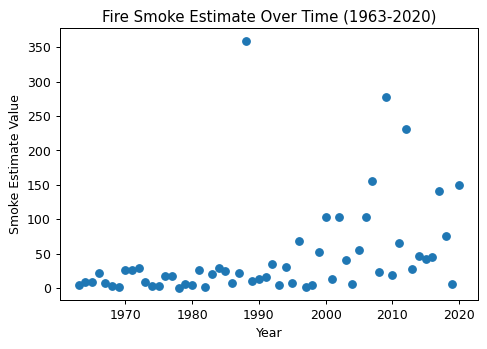

In [130]:
# plot year vs smoke estimate to visualize relationship 

# Reformat data to find average fire smoke estimate for each year
smoke_estimates = data.groupby('Fire_Year')['smoke_estimate'].mean().reset_index(drop=True)

# plot
plt.figure(dpi=90) 
plt.scatter(range(1963, 2021), smoke_estimates.values)

# label
plt.xlabel('Year')
plt.ylabel('Smoke Estimate Value')
plt.title('Fire Smoke Estimate Over Time (1963-2020)')

#### 2b.

Below, we fit a polynomial regression model of degree 2 to the data and plot the resulting fitted line over the data. Here, we find that the quadratic regression produces a quite good fit, and appears to perform better than a simple linear regression in that it captures the high variability on the right tail end of the data. 

We find that the model results in a r^2 coefficient of 0.1667. This statistic certainly does not imply that our model is great, but it does prove that the data are somewhat correlated, as indicated in the resulting plot.

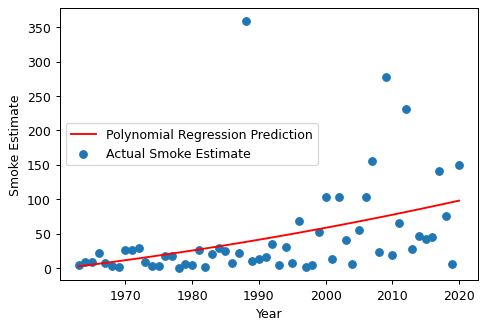

In [145]:
# define predictor and target variable
# no train and test set needed in this case
X = np.array(range(1963, 2021))
y = smoke_estimates.values

# using sci kit learn polynomial regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_transformed = poly.fit_transform(X.reshape(-1, 1))
reg = LinearRegression()
reg.fit(X_transformed, y)
y_pred = reg.predict(X_transformed)

# plot
plt.figure(dpi=90) 
plt.scatter(X, y, label='Actual Smoke Estimate')
plt.plot(X, y_pred, color='red', label='Polynomial Regression Prediction')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.legend()
plt.show()

In [143]:
r2_score(y, y_pred)

0.16671725358325962

#### 2c. 

We now use our predictive model to predict smoke estimates for every year for the next 25 years (i.e., 2024-2049). However, since we are extrapoloating in this case, it should be noted that this model is *highly* uncertain, and that these results should be taken lightly given that they essentially insinuate that the entire world will be covered in fire given enough time.

The polynomial fit also fails to capture much of the variability and outliers that are present in the data, which of course lends lower confidence in its predictions. Looking more specifically into the 80% confidence interval of the polynomial fit till year 2049 (highlighted on the plot in light blue), we see that as time goes on, our predicted smoke estimate becomes weaker and much more broad. By 2049, the model necessitates a range of nearly 300 smoke estimate units in order to establish 90% confidence. 

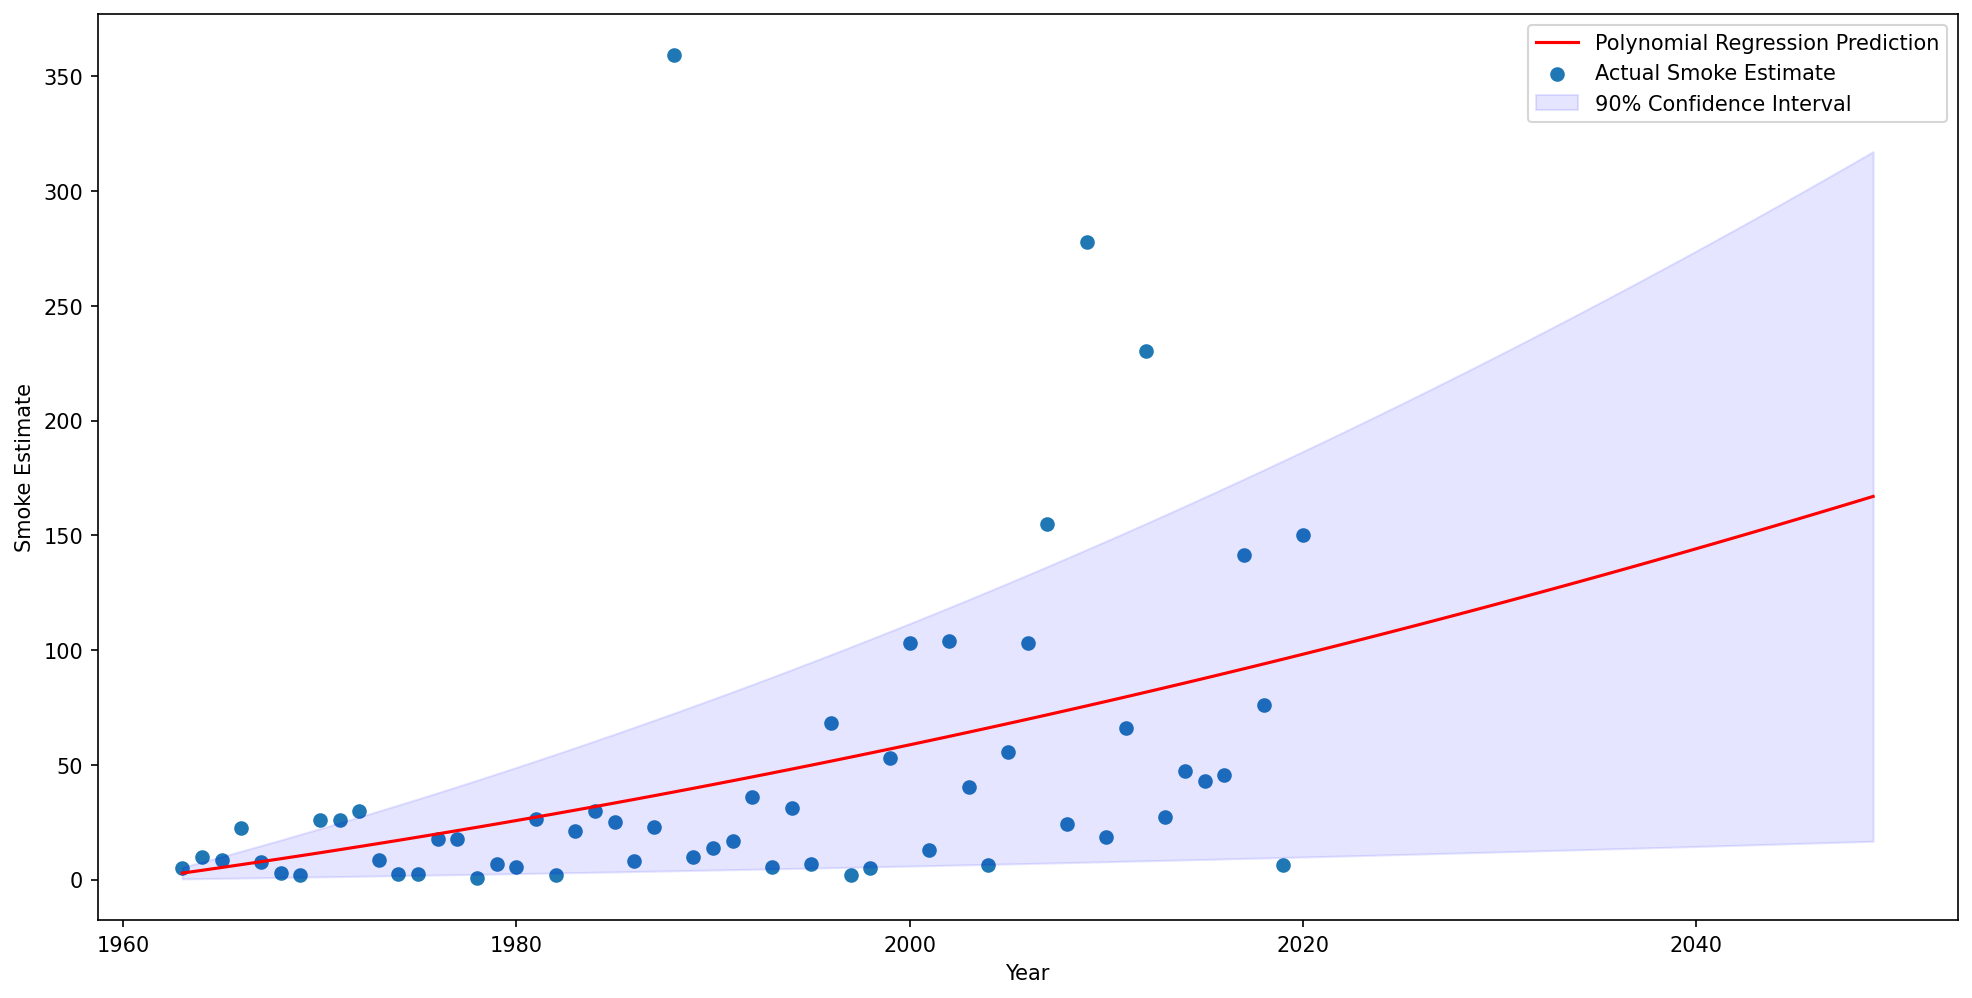

In [160]:
# same model as before

# this time X includes years up to 2049
X = np.array(range(1963, 2021))
y = smoke_estimates.values
poly = PolynomialFeatures(degree=2, include_bias=False)
X_transformed = poly.fit_transform(X.reshape(-1, 1))
reg = LinearRegression()
reg.fit(X_transformed, y)

# get future predictions
X_fut = np.array(range(1963, 2050))
X_transformed_fut = poly.fit_transform(X_fut.reshape(-1, 1))
y_pred = reg.predict(X_transformed_fut)

# get associated confidence interval (to show uncertainty of predictions)
confidence = .9
y_low, y_high = y_pred * (1 - confidence), y_pred * (1 + confidence)

# plot
plt.figure(figsize=(16, 8), dpi=150) 
plt.scatter(X, y, label='Actual Smoke Estimate')
plt.plot(X_fut, y_pred, color='red', label='Polynomial Regression Prediction')
plt.fill_between(X_fut, y_low, y_high, color='b', alpha=.1, label='90% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.legend()
plt.show()

## 3. Visualizations

### Plot 1.
Produce a histogram showing the number of fires occurring every 50 mile distance from Rapid City up to 1250 miles.

Visualizations are discussed in detail in ```reflection.pdf```.

Text(0.5, 1.0, 'Frequency of Wildfire of Varying Distances from Rapid City NV (1963-2020)')

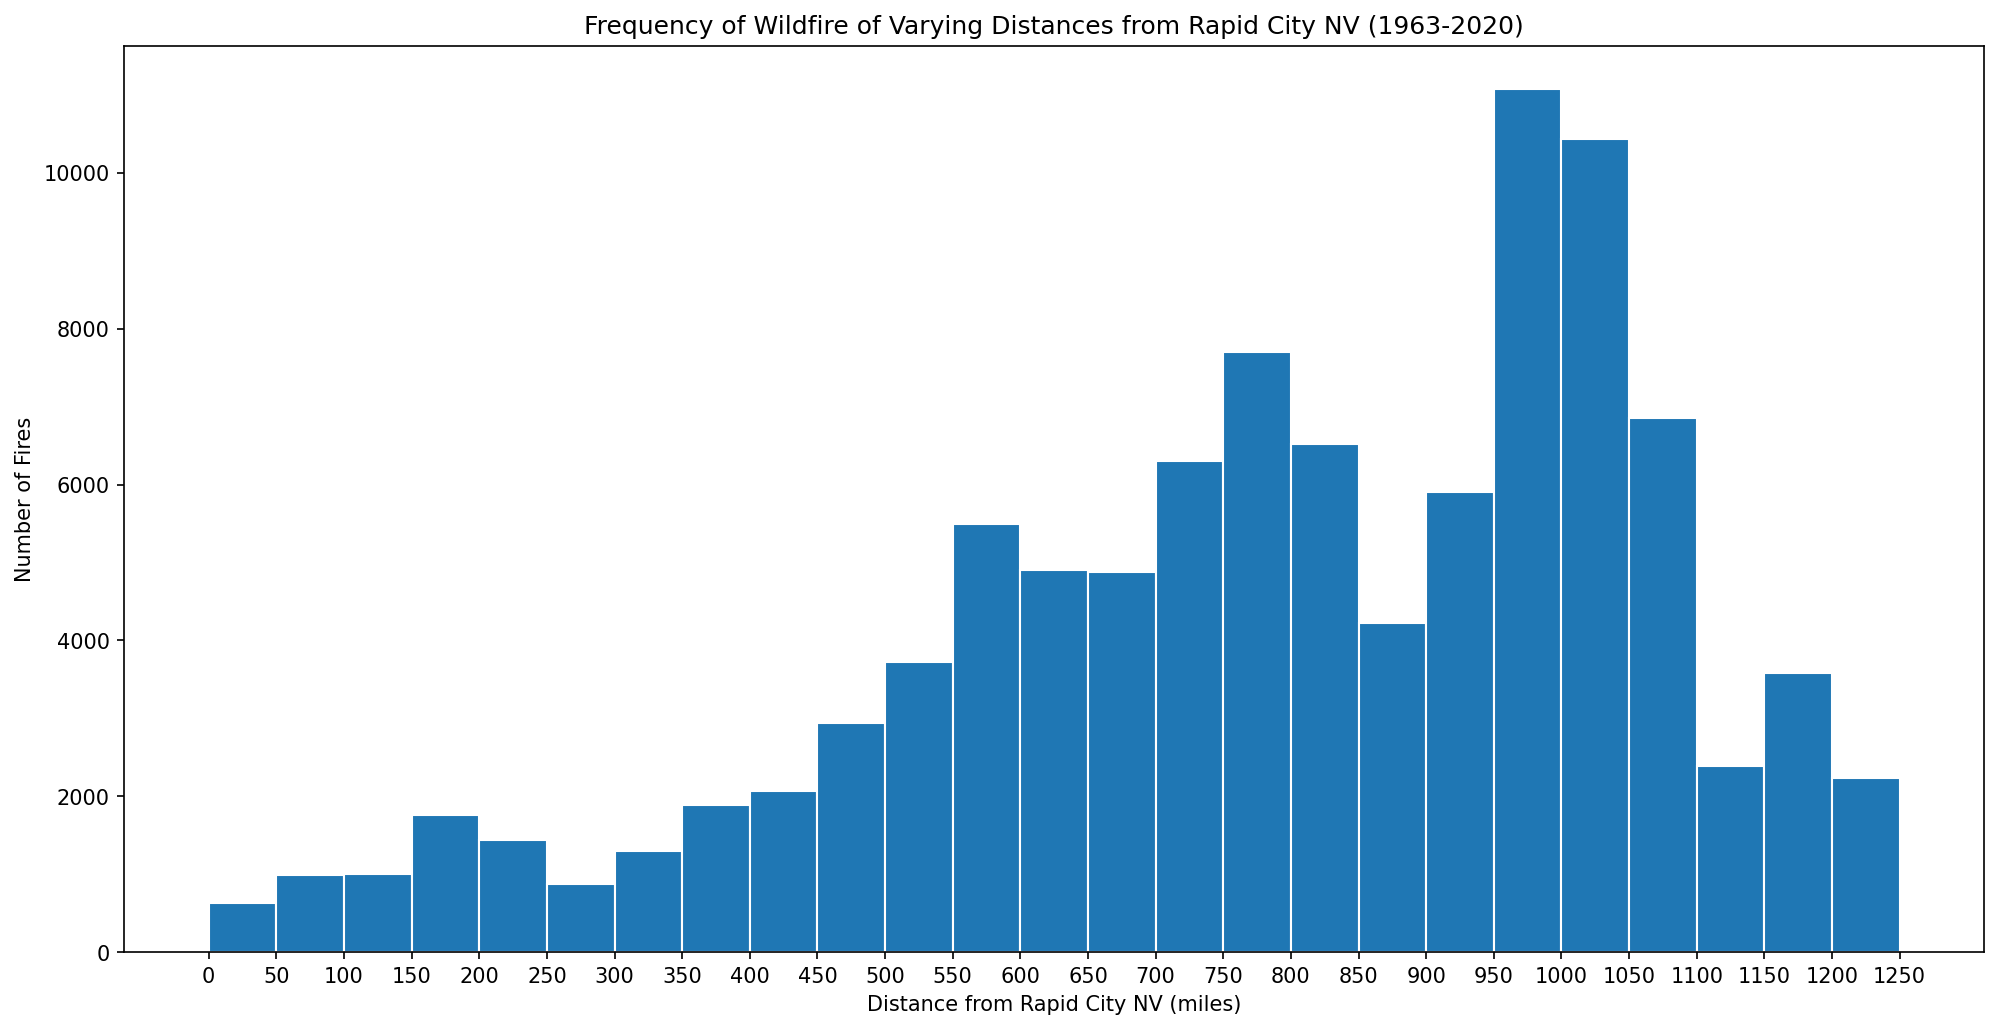

In [106]:
# Plot 1

dist = data['distance']

# Create histogram
plt.figure(figsize=(16, 8), dpi=150) 
plt.hist(dist,
         bins=range(0, 1300, 50),
         edgecolor='white')

plt.xticks(range(0, 1300, 50)) 
plt.xlabel('Distance from Rapid City NV (miles)')
plt.ylabel('Number of Fires')
plt.title('Frequency of Wildfire of Varying Distances from Rapid City NV (1963-2020)')

### Plot 2. 

Produce a time series graph of total acres burned per year for the fires occurring within 1250 miles of Rapid City.

Visualizations are discussed in detail in ```reflection.pdf```.

<Figure size 4800x2400 with 0 Axes>

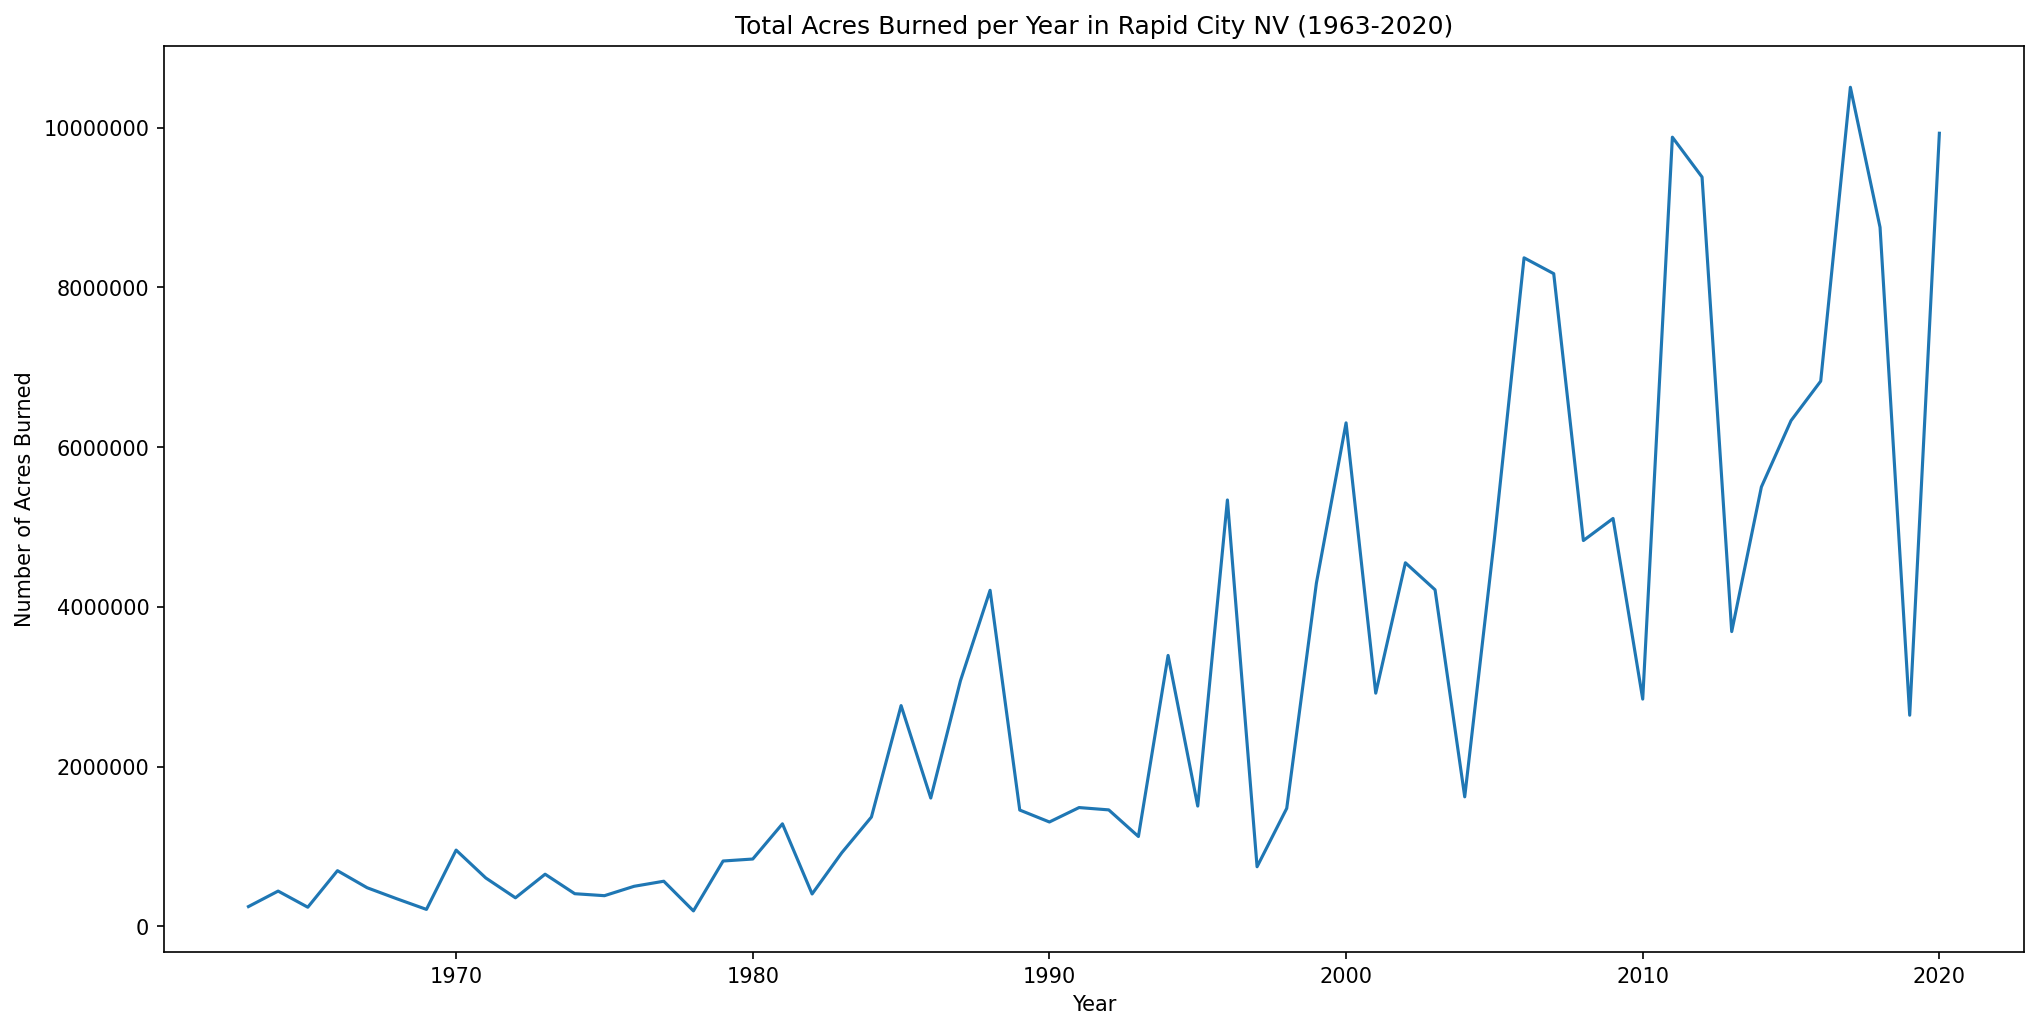

<Figure size 4800x2400 with 0 Axes>

In [83]:
# intermediate series to find the total number of acres burned per year
total_acres = data.groupby('Fire_Year')['GIS_Acres'].sum().reset_index(drop=True)

# plot
plt.figure(figsize=(16, 8), dpi=150) 
plt.plot(range(1963, 2021), total_acres.values)
plt.ticklabel_format(style='plain')

# label
plt.xlabel('Year')
plt.ylabel('Number of Acres Burned')
plt.title('Total Acres Burned per Year in Rapid City NV (1963-2020)')
plt.figure(figsize=(16, 8), dpi=300)

### Plot 3. 

Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

Visualizations are discussed in detail in ```reflection.pdf```.

<Figure size 4800x2400 with 0 Axes>

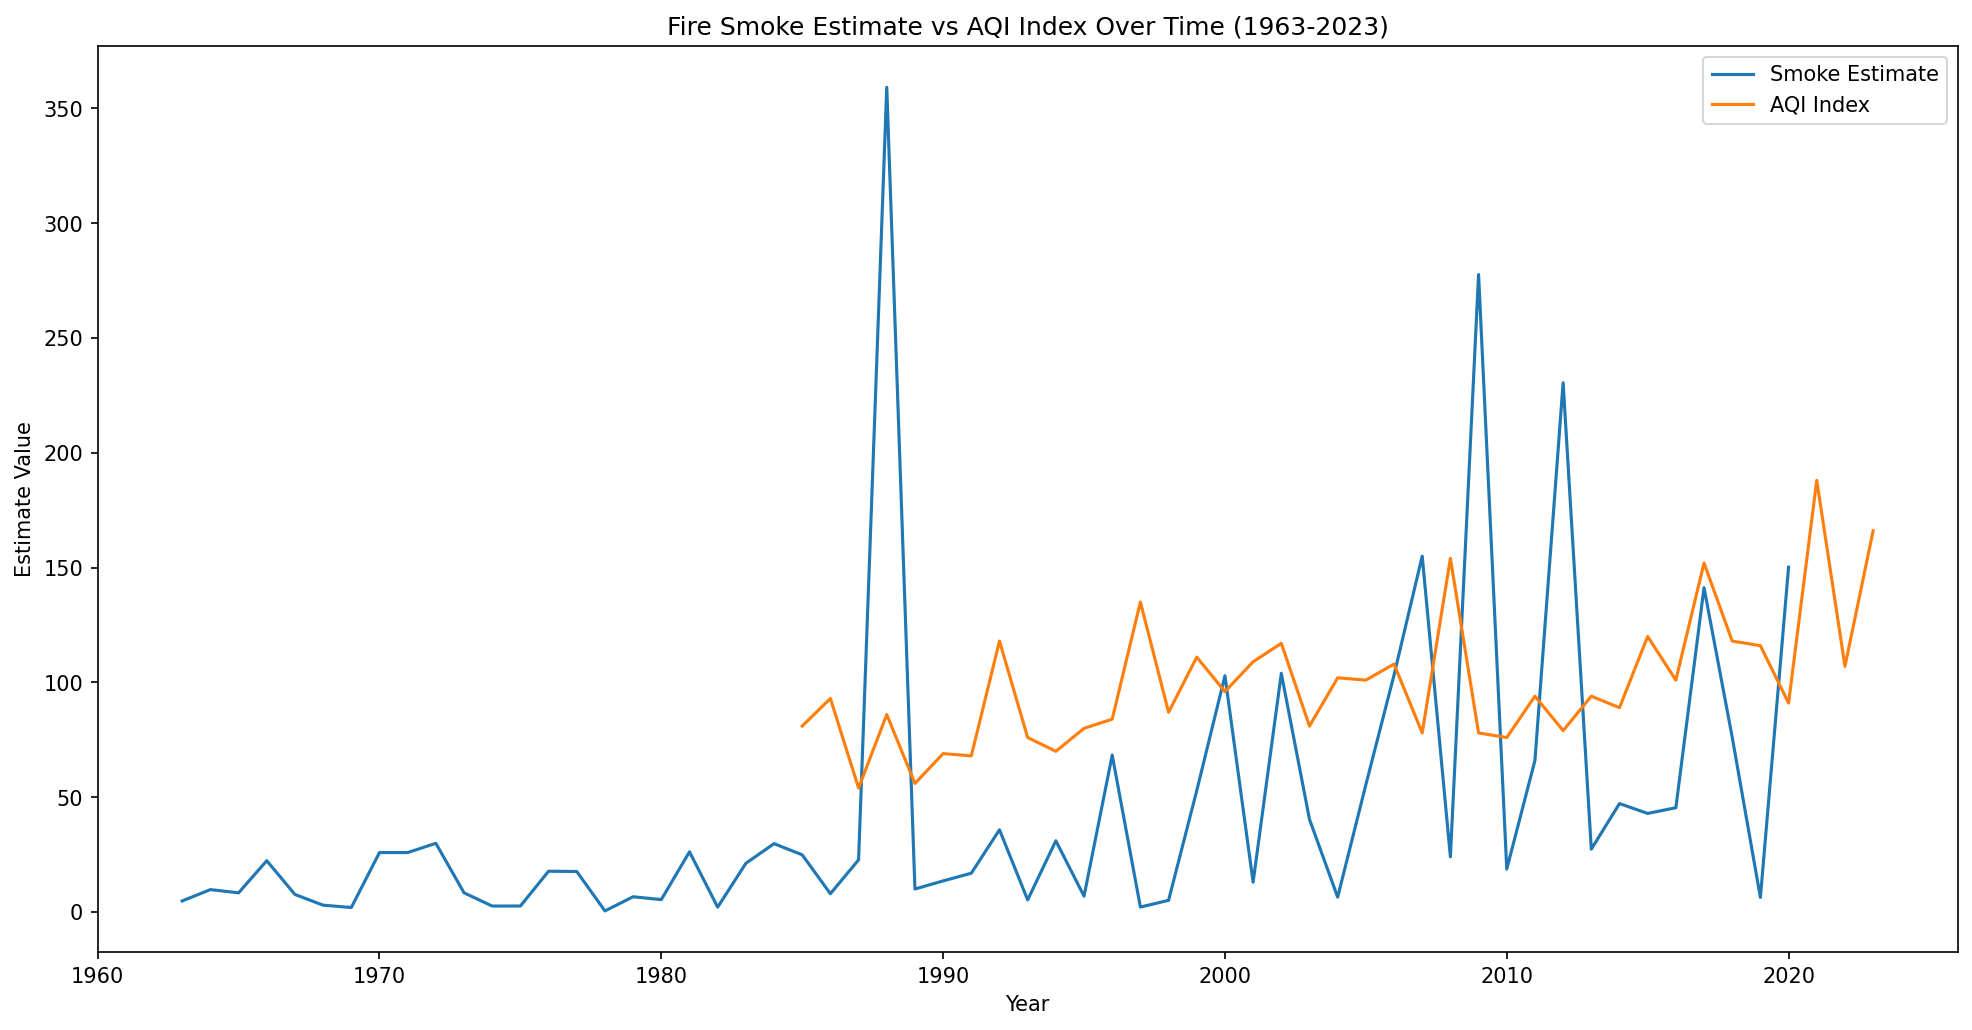

<Figure size 4800x2400 with 0 Axes>

In [103]:
# Reformat data to find average fire smoke estimate for each year
smoke_estimates = data.groupby('Fire_Year')['smoke_estimate'].mean().reset_index(drop=True)

# read in AQI data
aqi_data = pd.read_csv('./data/final_EPA_data.csv')[['year', 'aqi']]

# plot
plt.figure(figsize=(16, 8), dpi=150) 
plt.plot(range(1963, 2021), smoke_estimates.values, label='Smoke Estimate')
plt.plot(range(1985, 2024), aqi_data.aqi.values, label='AQI Index')
plt.ticklabel_format(style='plain')

# label
# add legend
plt.xlabel('Year')
plt.legend()
plt.ylabel('Estimate Value')
plt.title('Fire Smoke Estimate vs AQI Index Over Time (1963-2023)')
plt.figure(figsize=(16, 8), dpi=300)